<a href="https://colab.research.google.com/github/sahil3Vedi/digit-recogniser-py/blob/master/Deep_Learning_on_MNIST_without_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [278]:
#declaring all the dependencies NO KERAS OR TENSORFLOW
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
from google.colab import drive
from math import e
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Neural Network is Trained in 4 Stages:

1) Network recieves input from model
FUNCTION: NN.getInput(model.inputList)
VARIABLES INVOLVED: NN.layers[0].inputVals

2) Network activates one layer after the other.
FUNCTION: NN.activate(activationFunction)
VARIABLES INVOLVED: NN.layers[i].inputVals, NN.layers[i].activations, NN.layers[i].activDerivates, NN.layers[i].layerWeights, NN.layers[i].bias, NN.layers[i].biasWeights

3) Model calculates cost from the target value of input data and answer provided by network.
FUNCTION: model.getCost(NN)
VARIABLES INVOLVED: NN.layers[-1].activations, NN.layers[-1].forwardError, model.cost

4) Network readjusts the weights based on the cost and error information.
FUNCTION: NN.backpropagate()
VARIABLES INVOLVED: NN.layers[i].forwardError, NN.layers[i].diffWeights, NN.layers[i].diffBias, NN.layers[i-1].activations, NN.layers[i-1].forwardError

In [0]:
class neuralNetwork:
  layers=[]
  finalError=[]
  inputElem=0
  hiddenElem=0
  outputElem=0
  
  #When a neural network is declared 
  def __init__(self):
    self.inputElem=784
    self.outputElem=10
    self.hiddenElem=30
    
    inputLayer = layer(self.inputElem,"normalize",None)
    self.layers.append(inputLayer)
    
    temp = layer(self.hiddenElem,"tanH",self.layers[0])
    self.layers.append(temp)
    temp = layer(self.hiddenElem,"tanH",self.layers[1])
    self.layers.append(temp)
    temp = layer(self.hiddenElem,"tanH",self.layers[2])
    self.layers.append(temp)
    
    outputLayer = layer(self.outputElem,"softMax",self.layers[3])
    self.layers.append(outputLayer)
    #TOTAL 5 LAYERS
    print("Neural Network Initialised...")
    
  def getInput(self,i):
    self.layers[0].inputVals=i
    
  def dropout(self,x,y):
    stu=[]
    tempp=[]
    tempq=[]
    for i in range(len(x)):
      k=np.random.random_sample()
      m=x[i]
      n=y[i]
      if k<0:
        tempp.append(0)
        tempq.append(0)
      else:
        tempp.append(m)
        tempq.append(n)
    stu.append(tempp)
    stu.append(tempq)
    return stu
    
  def activate(self):
    for i in range(0,len(self.layers)):
      temp=self.layers[i].inputVals
      activation=self.layers[i].activation
      
      if (activation=="normalize"):#typically used for the input layer. if you ask me it makes perfect sense to treat normalisation as input layer activation.
        temp2=[(-1+(int(x)*2)/255) for x in temp]
        temp3=temp2 #this is because normalise is only being used on input layer where we dont need any back prop hence no need to calculate derivative.
      
      if (activation=="ReLU"):
        temp2=[]
        temp3=[]
        for x in temp:
          if (x>0):
            y=x
            z=1
          else:
            y=0.0000001*x
            z=0.0000001
          temp3.append(z)
          temp2.append(y)
          
      if (activation=="tanH"):
        temp2=[]
        temp3=[]
        for x in temp:
          a=e**(2.5*x)
          b=e**(-2.5*x)
          temp2.append((a-b)/(a+b))
        for y in temp2:
          temp3.append(2.5*(1-(y**2)))
          
      if (activation=="softMax"):
        evec=[e**x for x in temp]
        esum=np.sum(evec)
        temp2=[y/esum for y in evec]
        temp3=[q*(1-q) for q in temp2]
        
      if (activation=="tanH" or activation=="ReLU"):  
        stub=self.dropout(temp2,temp3)
      else:
        stub=[]
        stub.append(temp2)
        stub.append(temp3)
      
      self.layers[i].activations=stub[0]
      self.layers[i].activDerivatives=stub[1]
      
      if(i!=len(self.layers)-1):#this is because we dont need to feed forward beyond the output layer.
        self.layers[i].feedForward(self.layers[i+1])
  
  def backpropagate(self):
    for i in range(len(self.layers)):
      ind=-i-1
      if(i!=len(self.layers)-1):
        self.layers[ind].updateWeights(self.layers[ind-1])

In [0]:
class model:
  epoch=0
  learningRate=0.01
  cost=0
  target=0
  inputFile=[]
  trainingEntries=0
  accuracy=0
  accuracies=[]
  costs=[]
  epochs=[]
  
  def plotLoss(self):
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(self.epochs,self.accuracies)
    plt.show()
    
  def response(self,NN):
    #updating learning rate
    self.learningRate=(self.cost)*(0.01)/(0.449)
    maxI=max(NN.layers[-1].activations)
    indX=NN.layers[-1].activations.index(maxI)
    if(str(self.target)==str(indX)):
      self.accuracy+=1
    self.epoch+=1
    if(self.epoch%5000==0):
      self.plotLoss()
    if(self.epoch%500==0):
      print("Epoch: " + str(self.epoch) + " Cost: " + str(self.cost) + " Target: " + str((self.target)) + " Answer : " + str(indX))
      print(NN.layers[-3].activations)
      print("Accuracy: " + str(self.accuracy/5))
      #Adding accuracy cost and epoch for plotting.
      self.costs.append(self.cost)
      self.accuracies.append(self.accuracy/5)
      self.epochs.append(self.epoch)
      self.accuracy=0
      
  
  def getInput(self,inputFile):
    with open(inputFile) as csvFile:
      csvReader = csv.reader(csvFile)
      self.inputFile = list(csvReader)
      self.trainingEntries = len(self.inputFile)-1  #n-1 because first row is header row
      print("Total entries excluding header: " + str(self.trainingEntries) + " rows")
      
  def getCost(self,NN):
    targetVector=[]
    for i in range(10):
      if (str(i)==str(self.target)):
        targetVector.append(1)
      else:
        targetVector.append(0)
    output=NN.layers[-1].activations
    error=[x-y for (x,y) in zip(output,targetVector)]
    self.cost=0.5*(np.sum(np.square(error)))
    NN.layers[-1].forwardError=error
      
  def trainNetwork(self,NN):
    inputList=self.inputFile
    inputList.pop(0)
    for i in inputList:
      self.target=i[0]
      i.pop(0)
      NN.getInput(i)
      NN.activate()
      self.getCost(NN)
      NN.backpropagate()
      Model.response(NN)
      
  def invCross(self,l1,l2): #this is the ONLY part that
    temp=[]
    for x in l1:
      temptemp=[]
      for y in l2:
        temptemp.append(x*y)
      temp.append(temptemp)
    return temp
      

In [0]:
class layer:
  numberElements=0
  bias=0
  activation="default"
  inputVals=[]
  activations=[]
  activDerivatives=[]
  forwardError=[]
  layerWeights=[]
  biasWeights=[]
  
  #When a layer is declared
  def __init__(self,no_of_elements,activation,previousLayer):
    self.numberElements=no_of_elements
    self.bias=0.1
    self.activation=activation
    #Initialising the Weight Matrix
    temp=[]
    if(previousLayer!=None):
      for i in range(previousLayer.numberElements):
        temptemp=[]
        for j in range(self.numberElements):
          temptemp.append(np.tanh(0.3*(np.random.random_sample()-0.5)))
        temp.append(temptemp)
    self.layerWeights=temp
    #Initialising the Bias Matrix
    self.biasWeights=[]
    for i in range(self.numberElements):
      self.biasWeights.append(np.tanh(0.3*(np.random.random_sample()-0.5)))
      
  def feedForward(self,nextLayer):
    tempbias=self.bias
    biasVec=nextLayer.biasWeights
    temp2=np.matmul(self.activations,nextLayer.layerWeights)
    temp3=np.multiply(tempbias,biasVec)
    nextLayer.inputVals=[x+y for (x,y) in zip(temp2,temp3)]
    
  def updateWeights(self,prevLayer):
    #declaring the Differential diagonal matrix
    dmx=[]
    for i in range(self.numberElements):
      dtemp=[]
      oi=self.activations[i]
      for j in range(self.numberElements):
        if(i==j):
          dtemp.append(oi*(1-oi))
        else:
          dtemp.append(0)
      dmx.append(dtemp)
    #declaring do vector
    dovec=np.matmul(dmx,self.forwardError)
    wmx=Model.invCross(dovec,prevLayer.activations)
    bvec=np.multiply((self.bias*Model.learningRate),dovec)
    wMx=np.multiply(Model.learningRate,wmx)
    tempW=np.subtract(self.layerWeights,np.transpose(wMx))
    tempB=np.subtract(self.biasWeights,bvec)
    self.layerWeights=tempW
    prevLayer.forwardError=np.matmul(self.layerWeights,dovec)
    
    

Total entries excluding header: 42000 rows
Neural Network Initialised...
Epoch: 500 Cost: 0.46089662773040924 Target: 9 Answer : 1
[0.8437409540912242, -0.6146409051876929, 0.8655987830553367, 0.9449146864892438, -0.5967314340021491, 0.5767029314308981, 0.2954137824860275, 0.6874835791731497, 0.34402487623917904, 0.6276608676927745, 0.3554964744549561, -0.8351788473590643, -0.7401268147097333, 0.3573727046814801, -0.9269256154571933, 0.9960287179465155, 0.9395913619007132, -0.6416314435189696, -0.9344760975106096, 0.4659254962158659, 0.4015093864742837, -0.7774773664057828, 0.5167526325383898, 0.9595586183709761, -0.7025857828890587, -0.03646585063608774, 0.5880691984740155, -0.6875903461349756, -0.1449747346173575, 0.3132481338297789]
Accuracy: 10.6
Epoch: 1000 Cost: 0.4333885615427525 Target: 4 Answer : 2
[-0.9693337063543987, 0.6216838863723425, 0.8475751251451119, 0.5746475455620301, 0.6496596846565056, -0.17682203344113584, -0.6576750605069659, 0.2648697725906333, -0.4995337341297

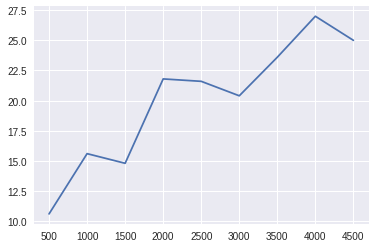

Epoch: 5000 Cost: 0.4520422375096166 Target: 9 Answer : 1
[-0.7788521627313147, 0.6490883812617675, 0.8528744104546876, 0.581357987528933, 0.6221011100270477, -0.2794442031561499, 0.5560747665673386, 0.4135473855548198, 0.26250935447618495, -0.2600196017820403, -0.6613348343778528, -0.590733540482416, -0.3000869443104613, 0.2689335987940717, 0.2227998255046604, 0.961036592494947, 0.7775783518108027, -0.9098396551036284, -0.8457503772435964, -0.512713605309207, 0.1416632746536555, 0.10956601744419812, -0.5665757304198471, -0.9702805133211811, 0.7365717856799022, -0.8699658182889013, -0.5676786344212218, 0.7219825484063187, 0.18826608791739688, 0.338878024119625]
Accuracy: 27.6
Epoch: 5500 Cost: 0.4486227897505632 Target: 4 Answer : 3
[-0.42848553843345344, 0.25242059019152696, 0.10639217191920376, 0.8411668323377263, -0.15377199425388638, 0.644732476656635, -0.17555812388326866, -0.5292059427132643, -0.8151321855897801, 0.7306622601296646, -0.9682474409517232, -0.75599049103493, 0.11029

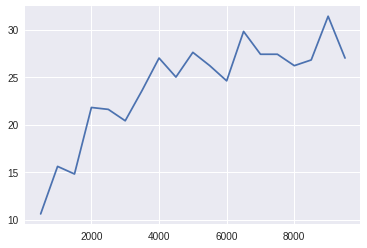

Epoch: 10000 Cost: 0.44265607397390616 Target: 9 Answer : 1
[-0.23552674064162105, 0.6038869616111976, 0.8838957776834486, 0.8092944877015835, -0.0746642281447734, 0.40271940683323965, -0.5434828892896427, 0.7067998708080449, 0.6469535606186982, -0.2158951011639744, -0.7573402842746005, 0.13109666963345487, 0.7658056717526549, -0.6647499839268368, 0.8451627812572835, 0.7924145835140213, 0.618493836291445, -0.8787592323610285, -0.6727186679188308, -0.5572672714690274, 0.7555737939884131, -0.2444175026843962, -0.5961295783917951, -0.7791580313783858, 0.6651851445538198, -0.8955793069274347, -0.8123444670158507, 0.9290668190820784, 0.4996357064569214, 0.4632550685783947]
Accuracy: 25.8
Epoch: 10500 Cost: 0.4494017798429549 Target: 9 Answer : 1
[-0.2363290259909199, 0.9149042372501396, 0.8910667684255675, 0.5930978002859322, 0.6112451452925415, -0.2262739187305482, -0.42704217640632786, 0.40014925390036726, -0.3282325326402847, 0.48395277506218937, -0.526661862901061, -0.4869361734874646, 

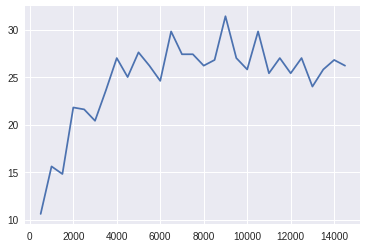

Epoch: 15000 Cost: 0.45105973452023307 Target: 6 Answer : 0
[0.2876447065711801, 0.716544362723976, 0.9757624846868486, 0.8958511148700533, -0.09279679291257568, 0.7121800536627538, -0.13001582718869803, 0.8709664527865192, 0.7803196174694212, -0.37780649000850597, -0.7040094609754665, 0.561985121144636, 0.4187710558756978, 0.1893542493840423, 0.7936744107628261, 0.9563230974593011, 0.38521099093494143, -0.8762674691066457, -0.34346134913257337, 0.028060853805677518, 0.08758690061981807, -0.7890257203695576, -0.5032832787187929, -0.848008209273687, 0.3566723956111047, -0.8577653882236462, -0.9703828136703597, 0.8849176297807416, 0.3614765033474005, 0.06095255691873632]
Accuracy: 27.6
Epoch: 15500 Cost: 0.3997636258632482 Target: 2 Answer : 2
[0.7673862514348359, 0.6429033567640786, 0.9761001166913258, 0.8846678785571281, 0.7611988020956197, 0.5182812231089333, 0.1781740554409406, 0.6071281307493566, -0.44440918450666783, 0.27703167217044256, -0.4613696955403774, -0.08663598675682707, 0

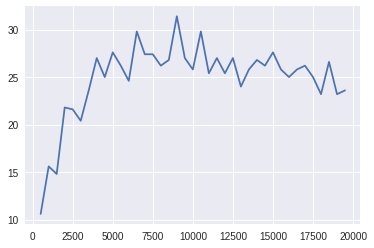

Epoch: 20000 Cost: 0.41344517110743395 Target: 7 Answer : 1
[-0.03706885367681201, 0.9053850764569431, 0.9280913827300956, 0.9750070833546595, -0.7285821877084924, 0.515903463476181, -0.33637462383881833, 0.9294295938396515, 0.42903998323687736, 0.07931686892512549, -0.6934091901419079, 0.4160688639735279, 0.587292715668166, -0.24649038382962135, -0.2961020148118189, 0.9828343263994208, 0.2691812026775276, -0.5154063746911154, -0.744513009276155, 0.10813104714798227, 0.4276711281012166, -0.942876676067161, -0.7288458154218761, -0.315413566209928, 0.5327528883256177, -0.8271540860183386, -0.0991880497957332, 0.8356922159311413, 0.4437563866824029, 0.8662166428077878]
Accuracy: 23.4
Epoch: 20500 Cost: 0.45255615006466 Target: 6 Answer : 1
[-0.026117085549653696, 0.8818613799916702, 0.916787190460639, 0.9791310764712781, -0.7119833495085944, 0.6586820307522734, -0.1927134924835327, 0.9000815594987767, 0.36183861665403755, 0.18281578734203913, -0.6820863437044309, 0.3470070292748594, 0.630

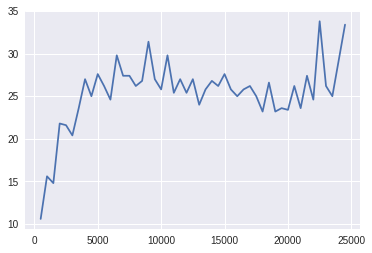

Epoch: 25000 Cost: 0.4610135795378727 Target: 5 Answer : 3
[0.23974477891766324, 0.6859251531867315, 0.9615249720545948, 0.9238684837216061, -0.003611954207637738, -0.3919582917713221, -0.6786866711151611, 0.7658305706415945, 0.4911259267397204, -0.7449521198404215, -0.8151504364683981, 0.9207186110831527, 0.8338139370549021, -0.6248615648943217, -0.1744404107438303, 0.9855015632178044, 0.6946229213056356, -0.8388049778870824, -0.43538819334043766, 0.42299196474211076, -0.47126764439619134, -0.755787886844627, -0.6597609241766736, -0.6134858819382468, 0.5379332319847321, -0.3991866556048123, 0.3451654214471398, 0.6726287324167287, 0.7047409818201549, 0.2730360264186774]
Accuracy: 31.6
Epoch: 25500 Cost: 0.42548576916761693 Target: 7 Answer : 0
[0.26184926130013925, 0.6608609184289215, 0.9257465443087045, 0.9241364208873285, -0.8794775490249143, 0.7493429955862636, 0.0422910283121492, 0.7659341683907624, 0.12996462806320402, 0.15544995360121389, -0.11101383350394804, -0.1153377015555198

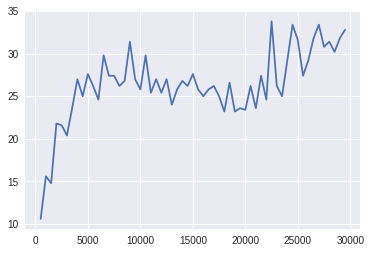

Epoch: 30000 Cost: 0.02406514169679641 Target: 0 Answer : 0
[0.10201562074571792, -0.47950002208765036, 0.8678296483714236, 0.741727072455205, 0.6900227975048895, -0.3402262454115878, -0.7536270979510593, -0.8371405516610269, -0.8015856460722247, -0.45064130351780596, -0.6574368046747481, -0.44942274778820773, 0.9478389895663709, -0.18300596021204776, 0.7477336282026033, 0.9940162609578714, 0.9145825319368938, -0.7980660510849131, 0.14674935922086044, 0.12326026068757746, 0.6513574228051153, 0.8171031858983283, -0.6438070353492782, -0.9193155654143909, 0.6776070971464757, -0.953325309632418, 0.3132445654965701, 0.8773830255093308, 0.9943329559190125, -0.600441387304307]
Accuracy: 31.2
Epoch: 30500 Cost: 0.429771085068812 Target: 8 Answer : 0
[-0.29603018394272473, 0.3535792330427487, 0.9141214315025041, 0.8621240742372781, 0.5135437748770116, -0.6479468746490715, -0.403853980119573, -0.5011622410181635, -0.349267349033135, -0.5708045200617385, -0.723289323762263, 0.3311348141205168, 0.

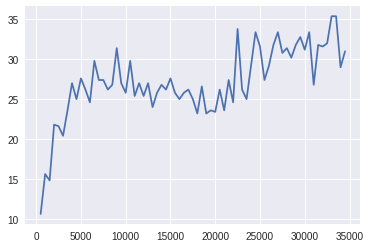

Epoch: 35000 Cost: 0.03761476465675893 Target: 0 Answer : 0
[0.2176416743512418, -0.5893104250362545, 0.9719459818736194, 0.9052149817037373, 0.8512090703092141, -0.49147633212498265, -0.8310566548194676, -0.12705465188032924, -0.9486220973158711, -0.617967433132546, 0.495345343576211, -0.5015630099990641, 0.9308620677716959, -0.48017619516625587, 0.5204316991350588, 0.9718644391827288, 0.8359806401937317, -0.40500408568467017, -0.23633718937412004, 0.3609413810221712, -0.4187238108157683, 0.08104787790382026, -0.2799721007021593, -0.6800337879029547, -0.4334266287585541, -0.8172780474523307, 0.5232034093047786, 0.6080740132124222, 0.8967277416828197, -0.14660292295118818]
Accuracy: 31.2
Epoch: 35500 Cost: 0.4460173271839544 Target: 2 Answer : 7
[-0.6175081009802136, 0.7565822709089196, 0.5310216166658669, 0.9125949586652139, -0.6932820210631603, 0.792868175121522, 0.8332414692772908, 0.8522762358681732, 0.8730309311947132, -0.7114628603019121, -0.490585862491327, 0.17058865767480882, 

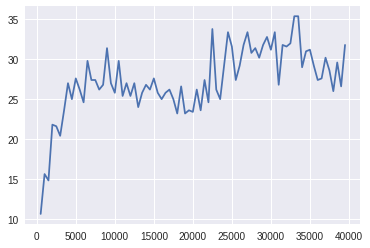

Epoch: 40000 Cost: 0.4402011800129698 Target: 3 Answer : 4
[-0.6948385980789293, 0.7717740432331951, 0.5382583142862568, 0.9410897776313148, -0.40448176177481404, 0.18602928936352386, -0.3565134459416057, -0.2689608015596294, 0.7650485124795771, -0.8030459166294285, -0.32313487431563803, 0.6986110864137254, 0.8783015473787681, -0.9945312600363349, 0.2967337770838435, 0.977600018768229, -0.45181441805460015, -0.6450309240359926, 0.7825320604722007, 0.2756882117067202, 0.6885596140424652, 0.4711697637329918, -0.020190166673845975, -0.027911571964434133, 0.5316831755465946, -0.8008965151857214, 0.023375672912213482, 0.9519999400781323, 0.9834516504859255, 0.5780800721963733]
Accuracy: 32.8
Epoch: 40500 Cost: 0.4061027210084729 Target: 4 Answer : 7
[-0.6152640862299862, 0.6242829835782339, 0.0992671448388461, 0.9688660084048674, -0.796765076058133, 0.6331332725953006, -0.44232041435903624, 0.11350256156924779, 0.8451449048000715, -0.6856493989537603, -0.18735988022579111, 0.872660754780443

In [282]:
#-----MAIN FUNCTION-----

Model = model()
inputFile='drive/My Drive/MNIST Image CSV/train.csv'
Model.getInput(inputFile)

NN = neuralNetwork()
Model.trainNetwork(NN)